In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from tqdm import tqdm
import os
from pathlib import Path

os.chdir("../..")
os.getcwd()

'/home/bwool/RESEARCH/TRB-Home-Data-Quality-2025'

# User-Level Data Quality Metrics (2019 Sample Data)

## Overview

This notebook computes per-user data quality metrics from cleaned mobile location data.

Key steps:
- Load cleaned Parquet files
- Compute metrics: record count, device type, accuracy, night coverage
- Save per-user metrics as CSVs

📁 Input: `00_Data/02_Cleaned_Sample_Data/`  
📁 Output: `00_Data/03_Metrics_Sample_Data/`


## User Metric Computation Function

In [2]:
def compute_user_metrics(
    data: pd.DataFrame,
    output_filepath: str = None,
    night_start_hour: int = 19, # 7pm
    night_end_hour: int = 7     # 7am
) -> pd.DataFrame:
    # === Core metrics ===
    total_records = data.groupby('caid').size().rename('total_records')
    prop_ios = data.groupby('caid')['is_iOS'].mean().rename('prop_ios').astype(float)

    data['date'] = data['datetime_pdt'].dt.date
    days_with_data = data.groupby('caid')['date'].nunique().rename('days_with_data')

    prop_high_accuracy = (
        data.groupby('caid')['horizontal_accuracy']
        .apply(lambda x: (x <= 100).mean())
        .rename('prop_high_accuracy')
    )
    # === Night & bin labels ===
    data['hour'] = data['datetime_pdt'].dt.hour
    data['minute'] = data['datetime_pdt'].dt.minute
    data['is_night'] = ((data['hour'] >= night_start_hour) | (data['hour'] < night_end_hour))
    data['night_date'] = data['datetime_pdt'].dt.date
    data.loc[data['hour'] < night_end_hour, 'night_date'] -= pd.Timedelta(days=1)

    mask_night = data['is_night']
    data.loc[mask_night, 'night_minute'] = data.loc[mask_night, 'hour'] * 60 + data.loc[mask_night, 'minute']
    data.loc[mask_night, 'night_bin'] = data.loc[mask_night, 'night_minute'] // 30

    # === Night metrics ===
    temp = data.loc[mask_night, ['caid', 'night_date', 'night_bin']].copy()
    night_counts = (
        temp.groupby('caid')
        .agg(
            total_night_pings=('night_date', 'count'),
            unique_nights=('night_date', 'nunique')
        )
    )
    night_counts['avg_night_pings_per_night'] = (
        night_counts['total_night_pings'] / night_counts['unique_nights']
    )
    # === Bin-level stats ===
    bins_per_night = (
        temp.groupby(['caid', 'night_date'])['night_bin']
        .nunique()
        .rename('bins_this_night')
    ).reset_index()

    avg_bins_per_night = (
        bins_per_night.groupby('caid')['bins_this_night']
        .mean()
        .rename('avg_bins_per_night')
    )
    # === Combine all metrics ===
    user_metrics = pd.concat([
        total_records,
        prop_ios,
        days_with_data,
        prop_high_accuracy
    ], axis=1).reset_index()

    user_metrics = (
        user_metrics
        .merge(night_counts.reset_index(), on='caid', how='left')
        .merge(avg_bins_per_night.reset_index(), on='caid', how='left')
    )

    # === Save to CSV ===
    if output_filepath:
        user_metrics.to_csv(output_filepath, index=False)

    return user_metrics


## Compute and Save User Metrics

In [ ]:
def compute_2019_metrics():
    # === Set up folder and file list ===
    folder_2019_cleaned = "00_Data/02_Cleaned_Sample_Data/2019_Cleaned_Data"
    output_folder = "00_Data/03_Metrics_Sample_Data"
    os.makedirs(output_folder, exist_ok=True)

    cleaned_files = [os.path.join(folder_2019_cleaned, f) for f in os.listdir(folder_2019_cleaned) if f.endswith(".parquet")]

    # === Process each cleaned parquet ===
    for filepath in tqdm(cleaned_files, desc="Computing user metrics"):
        try:
            # Load cleaned data
            data = pd.read_parquet(filepath, engine="pyarrow")

            # Compute metrics
            user_metrics = compute_user_metrics(data)

            # Build output CSV path
            filename_base = os.path.basename(filepath).replace(".parquet", "_metrics.csv")
            output_path = os.path.join(output_folder, filename_base)

            # Save metrics
            user_metrics.to_csv(output_path, index=False)

            print(f"{filename_base}: {len(user_metrics):,} users processed")

        except Exception as e:
            print(f"Error processing {filepath}: {e}")

# compute_2019_metrics()

Computing user metrics:  11%|█         | 1/9 [00:26<03:30, 26.30s/it]

part-00001-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,700 users processed


Computing user metrics:  22%|██▏       | 2/9 [00:52<03:02, 26.06s/it]

part-00002-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,482 users processed


Computing user metrics:  33%|███▎      | 3/9 [01:18<02:35, 25.97s/it]

part-00003-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,316 users processed


Computing user metrics:  44%|████▍     | 4/9 [01:44<02:10, 26.07s/it]

part-00000-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,579 users processed


Computing user metrics:  56%|█████▌    | 5/9 [02:09<01:43, 25.87s/it]

part-00005-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,577 users processed


Computing user metrics:  67%|██████▋   | 6/9 [02:34<01:16, 25.64s/it]

part-00007-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,467 users processed


Computing user metrics:  78%|███████▊  | 7/9 [03:00<00:51, 25.67s/it]

part-00004-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,573 users processed


Computing user metrics:  89%|████████▉ | 8/9 [03:26<00:25, 25.64s/it]

part-00008-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,564 users processed


Computing user metrics: 100%|██████████| 9/9 [03:51<00:00, 25.67s/it]

part-00006-85a0c7d9-db42-457d-ab9d-d104038b7a1e-c000.snappy_metrics.csv: 17,483 users processed


##  User Metrics Tracked

| **Metric**                   | **Description**                                          |
|-----------------------------|----------------------------------------------------------|
| `total_records`             | Total number of observations for the user               |
| `prop_ios`                  | Share of observations from iOS devices                  |
| `days_with_data`            | Unique calendar days with observations                  |
| `prop_high_accuracy`        | Share of pings with horizontal accuracy ≤ 100 meters    |
| `total_night_pings`         | Count of nighttime pings (7PM–7AM)                      |
| `unique_nights`             | Unique nights with at least one ping                    |
| `avg_night_pings_per_night`| Average pings per night (if any)                        |
| `avg_bins_per_night`        | Average 30-min bins covered per night                  |


## Load and Combine User Metrics

In [5]:
def load_all_user_metrics(folder_path: str) -> pd.DataFrame:
    csv_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".csv")
    ]

    df_list = []
    for f in csv_files:
        df = pd.read_csv(f)
        df_list.append(df)

    combined = pd.concat(df_list, ignore_index=True)
    return combined
metrics_folder = "00_Data/03_Metrics_Sample_Data"
all_user_metrics = load_all_user_metrics(metrics_folder)
print(f"Loaded {len(all_user_metrics):,} users from {len(os.listdir(metrics_folder))} files")

Loaded 157,741 users from 9 files


In [13]:
all_user_metrics.memory_usage(deep=True).sum() / (1024 ** 2)


26.62686252593994

# plotting

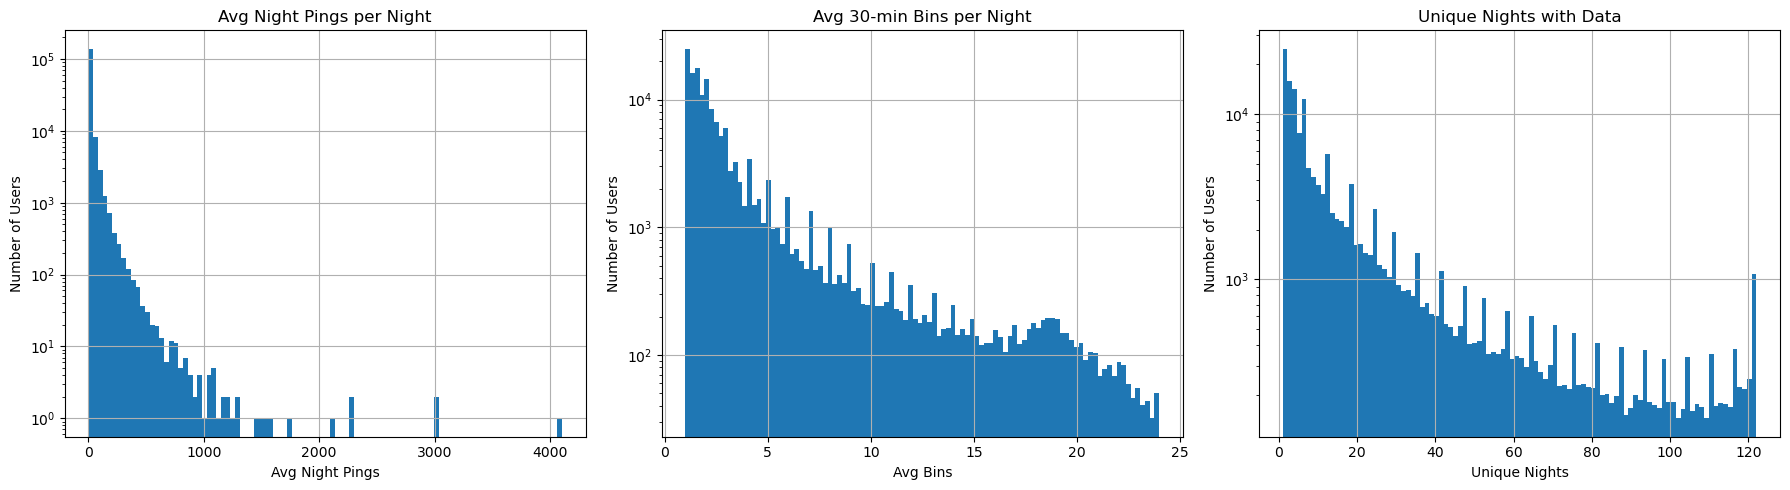

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
bin_count = 100

# Submetric 1: Avg Night Pings per Night
axs[0].hist(all_user_metrics['avg_night_pings_per_night'].dropna(), bins=bin_count)
axs[0].set_title('Avg Night Pings per Night')
axs[0].set_xlabel('Avg Night Pings')
axs[0].set_ylabel('Number of Users')

# Submetric 2: Avg Bins per Night
axs[1].hist(all_user_metrics['avg_bins_per_night'].dropna(), bins=bin_count)
axs[1].set_title('Avg 30-min Bins per Night')
axs[1].set_xlabel('Avg Bins')
axs[1].set_ylabel('Number of Users')

# Submetric 3: Unique Nights
axs[2].hist(all_user_metrics['unique_nights'].dropna(), bins=bin_count)
axs[2].set_title('Unique Nights with Data')
axs[2].set_xlabel('Unique Nights')
axs[2].set_ylabel('Number of Users')

for ax in axs:
    ax.grid(True)
    ax.set_yscale('log')
plt.tight_layout()
plt.show()


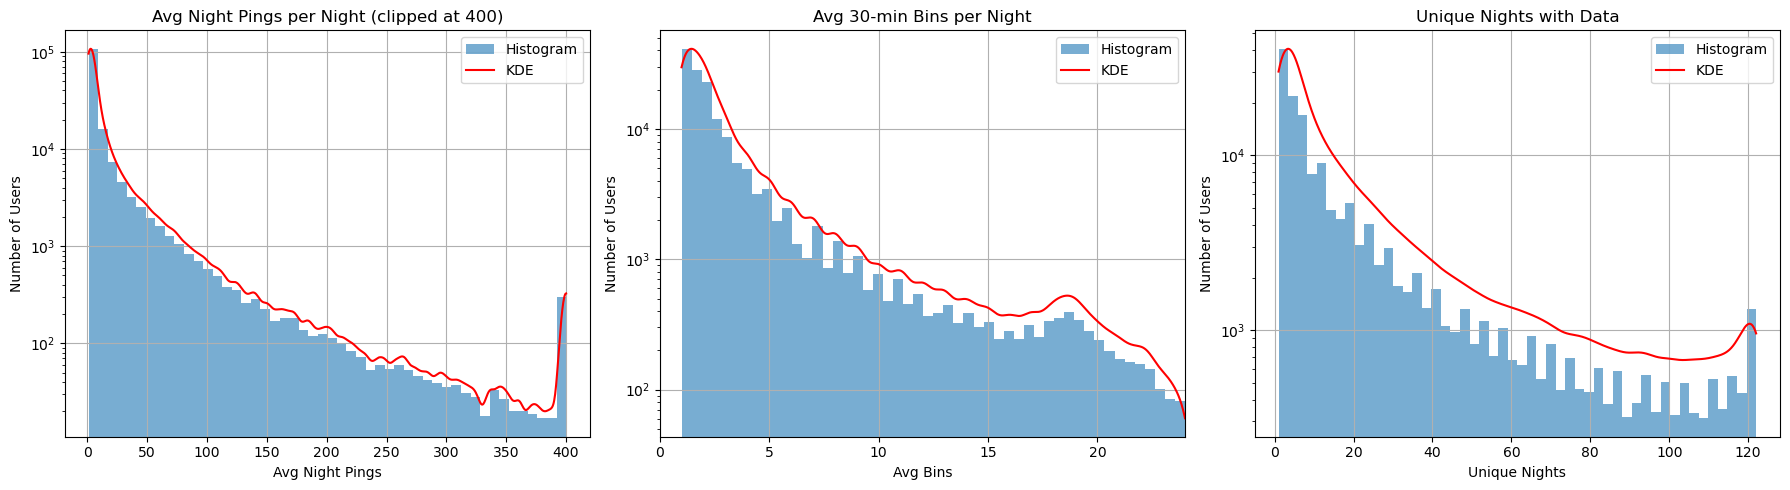

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
bin_count = 50

# --- Helper to add KDE ---
def plot_hist_with_kde(ax, data, bins, title, xlabel):
    # Histogram
    counts, bins, patches = ax.hist(data, bins=bins, alpha=0.6, label='Histogram')

    # KDE
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    kde_vals = kde(x_vals)
    # Scale KDE to histogram height
    kde_scaled = kde_vals * max(counts) / max(kde_vals)
    ax.plot(x_vals, kde_scaled, color='red', label='KDE')

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number of Users')
    ax.legend()
    ax.grid(True)
    ax.set_yscale('log')

# --- Submetric 1: Log-space KDE ---
data = all_user_metrics['avg_night_pings_per_night'].dropna()
clip_max = 400
data_clipped = np.clip(data, 0, clip_max)  # Clip huge outliers for clean plot

# KDE in linear space, but clipped
kde = gaussian_kde(data_clipped)
x_vals = np.linspace(data_clipped.min(), data_clipped.max(), 1000)
kde_vals = kde(x_vals)

counts, bins, patches = axs[0].hist(data_clipped, bins=bin_count, alpha=0.6, label='Histogram')
kde_scaled = kde_vals * max(counts) / max(kde_vals)
axs[0].plot(x_vals, kde_scaled, color='red', label='KDE')

axs[0].set_title(f'Avg Night Pings per Night (clipped at {clip_max})')
axs[0].set_xlabel('Avg Night Pings')
axs[0].set_ylabel('Number of Users')
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log')

# --- Submetric 2 ---
plot_hist_with_kde(
    axs[1],
    all_user_metrics['avg_bins_per_night'].dropna(),
    bins=bin_count,
    title='Avg 30-min Bins per Night',
    xlabel='Avg Bins'
)
axs[1].set_xlim(0,24)
# --- Submetric 3 ---
plot_hist_with_kde(
    axs[2],
    all_user_metrics['unique_nights'].dropna(),
    bins=bin_count,
    title='Unique Nights with Data',
    xlabel='Unique Nights'
)

plt.tight_layout()
plt.show()


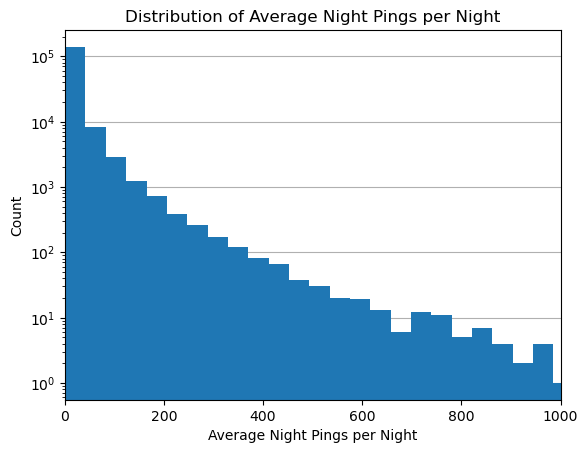

In [9]:
# Feature to plot
feature = 'avg_night_pings_per_night'

fig, ax = plt.subplots()
ax.hist(all_user_metrics[feature], bins=100)
ax.set_title('Distribution of Average Night Pings per Night')
ax.set_xlabel('Average Night Pings per Night')
ax.set_ylabel('Count')
ax.grid(axis='y', zorder=0)

for bar in ax.patches:
    bar.set_zorder(2)

ax.set_xlim(left=0, right=1000)
ax.set_yscale('log')
plt.show()

In [10]:
all_user_metrics['avg_night_pings_per_night'].describe()

count    153194.000000
mean         16.259695
std          46.477693
min           1.000000
25%           2.000000
50%           3.600000
75%          11.888889
max        4103.000000
Name: avg_night_pings_per_night, dtype: float64

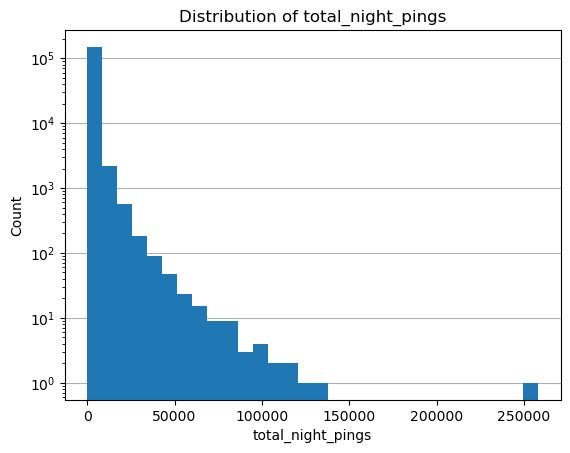

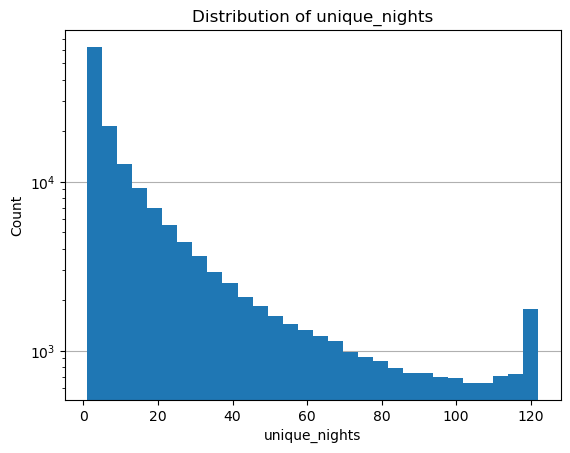

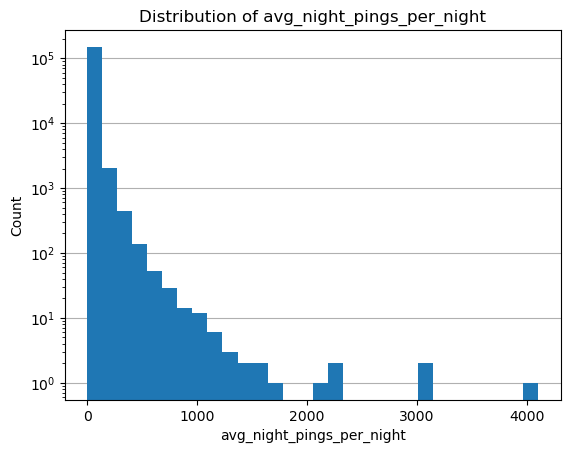

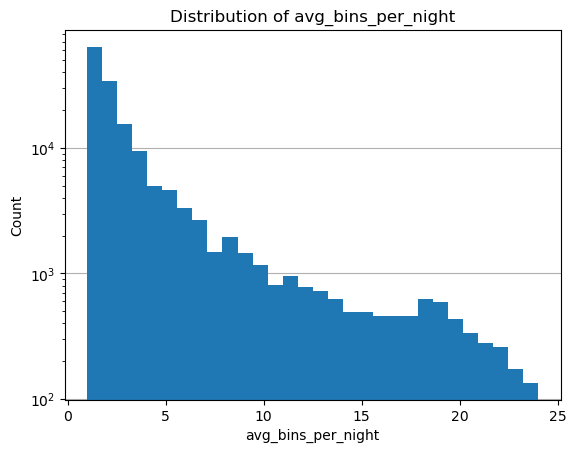

In [12]:
# Features to plot
features = [
    'total_night_pings',
    'unique_nights',
    'avg_night_pings_per_night',
    'avg_bins_per_night',
]

# Plot each feature
for feature in features:
    fig, ax = plt.subplots()
    ax.hist(all_user_metrics[feature], bins=30)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.grid(axis='y', zorder=0)
    for bar in ax.patches:
        bar.set_zorder(2)
    plt.show()